In [5]:
import torch 
import torch.nn as nn
import os
from PIL import Image
import numpy as np
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from torchsummary import summary
import time

# Check if GPU is available and set the device accordingly
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# cristian path 
base_dir = '/home/csalitre/school/ecgr-5106/final-project/' 

train_path = base_dir + 'semantic-segmentation/train2/' 
valid_path = base_dir + 'semantic-segmentation/valid2/'
test_path = base_dir + 'semantic-segmentation/test2/'

image_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485], std=[0.229]),  # Assuming grayscale images
    transforms.Lambda(lambda x: x.clamp(0, 1))
])

# Custom DiceLoss for training
class DiceLoss(torch.nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()

    def forward(self, logits, targets, smooth=1e-6):
        intersection = torch.sum(logits * targets)
        dice_coefficient = (2. * intersection + smooth) / (torch.sum(logits) + torch.sum(targets) + smooth)
        return 1.0 - dice_coefficient

class BrainDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.image_folder = os.path.join(root_dir, "images")
        self.mask_folder = os.path.join(root_dir, "masks")
        self.image_files = sorted(os.listdir(self.image_folder))
        self.mask_files = sorted(os.listdir(self.mask_folder))
        self.transform = transform

        # Print lengths of image_files and mask_files for debugging
        print(f"Length of image files: {len(self.image_files)}")
        print(f"Length of mask files: {len(self.mask_files)}")

     # Check consistency of image and mask files
        if len(self.image_files) != len(self.mask_files):
            mismatched_file_index = len(self.image_files) if len(self.image_files) < len(self.mask_files) else len(self.mask_files)
            print(f"Mismatched files: {self.image_files[mismatched_file_index]}")
            raise ValueError("Number of images and masks do not match.")
    
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self,idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_folder, img_name)
        image_gray = Image.open(img_path).convert("L")  # Convert to grayscale
        mask_name = self.mask_files[idx]
        mask_path = os.path.join(self.mask_folder, mask_name)
        mask = Image.open(mask_path).convert("L")
        
        if self.transform:
            # Apply transformations
            image_gray = self.transform(image_gray)
            mask = self.transform(mask)
        return image_gray, mask
    
class CNN_EncoderDecoder(nn.Module):
    def __init__(self, in_chans=1, out_chans=32, sampling_factor=2, dropout_prob=0.5):
        super(CNN_EncoderDecoder, self).__init__()
        
        # Encoder layers
        self.enc_conv1 = nn.Conv2d(in_chans, out_chans, kernel_size=3, padding=1)
        self.enc_bn1 = nn.BatchNorm2d(out_chans)
        self.enc_relu1 = nn.ReLU(inplace=True)
        self.enc_pool1 = nn.MaxPool2d(kernel_size=sampling_factor)  # Halves dimension
        
        self.enc_conv2 = nn.Conv2d(out_chans, out_chans * 2, kernel_size=3, padding=1)
        self.enc_bn2 = nn.BatchNorm2d(out_chans * 2)
        self.enc_relu2 = nn.ReLU(inplace=True)
        self.enc_pool2 = nn.MaxPool2d(kernel_size=sampling_factor)  # Halves dimension
        
        self.enc_conv3 = nn.Conv2d(out_chans * 2, out_chans * 4, kernel_size=3, padding=1)
        self.enc_bn3 = nn.BatchNorm2d(out_chans * 4)
        self.enc_relu3 = nn.ReLU(inplace=True)
        self.enc_pool3 = nn.MaxPool2d(kernel_size=sampling_factor)  # Halves dimension, final small latent space
        
        # Decoder layers
        self.dec_upconv1 = nn.ConvTranspose2d(out_chans * 4, out_chans * 2, kernel_size=2, stride=2)
        self.dec_bn1 = nn.BatchNorm2d(out_chans * 2)
        self.dec_relu1 = nn.ReLU(inplace=True)
        self.dec_dropout1 = nn.Dropout(p=dropout_prob)  # Dropout after activation
        
        self.dec_upconv2 = nn.ConvTranspose2d(out_chans * 2, out_chans, kernel_size=2, stride=2)
        self.dec_bn2 = nn.BatchNorm2d(out_chans)
        self.dec_relu2 = nn.ReLU(inplace=True)
        self.dec_dropout2 = nn.Dropout(p=dropout_prob)  # Dropout after activation
        
        self.dec_upconv3 = nn.ConvTranspose2d(out_chans, in_chans, kernel_size=2, stride=2)
        self.dec_sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Encoder
        x1 = self.enc_conv1(x)
        x1 = self.enc_bn1(x1)
        x1 = self.enc_relu1(x1)
        x1p = self.enc_pool1(x1)
        
        x2 = self.enc_conv2(x1p)
        x2 = self.enc_bn2(x2)
        x2 = self.enc_relu2(x2)
        x2p = self.enc_pool2(x2)
        
        x3 = self.enc_conv3(x2p)
        x3 = self.enc_bn3(x3)
        x3 = self.enc_relu3(x3)
        x3p = self.enc_pool3(x3)
        
        # Decoder
        x3d = self.dec_upconv1(x3p)
        x3d = self.dec_bn1(x3d)
        x3d = self.dec_relu1(x3d)
        x3d = self.dec_dropout1(x3d)
        
        x2d = self.dec_upconv2(x3d)
        x2d = self.dec_bn2(x2d)
        x2d = self.dec_relu2(x2d)
        x2d = self.dec_dropout2(x2d)
        
        x1d = self.dec_upconv3(x2d)
        x1d = self.dec_sigmoid(x1d)
        
        return x1d



train_dataset = BrainDataset(train_path, transform=image_transform)
valid_dataset = BrainDataset(valid_path, transform=image_transform)
test_dataset = BrainDataset(test_path, transform=image_transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
    

def train(model, train_loader, valid_loader, num_epochs, learning_rate):
    # Define loss function
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Move model to device
    model.to(device)
    summary(model, (1, 256, 256))
    
    
    train_loss_history = []
    valid_loss_history = []

    start_time = time.time()

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        correct_train = 0
        total_train =0
        for images, masks in train_loader:
            images, masks = images.to(device), masks.to(device)

            optimizer.zero_grad() # zero out the gradients
            outputs = model(images)
            #print(outputs.shape)
            loss = criterion(outputs, masks)

            loss.backward() # back propagate the loss
            optimizer.step()    # update the weights
            train_loss += loss.item() # add the loss to the train loss

            predicted = outputs > 0.5   # threshold the outputs to get the predicted masks
            correct_train += (predicted == masks).sum().item()
            total_train += masks.numel()

        train_accuracy = correct_train / total_train

        # Validation loop
        model.eval()
        valid_loss = 0.0
        correct_valid = 0
        total_valid = 0
        with torch.no_grad():
            for images, masks in valid_loader:
                images, masks = images.to(device), masks.to(device)

                outputs = model(images)
                loss = criterion(outputs, masks)
                valid_loss += loss.item()

                predicted = outputs > 0.5
                correct_valid += (predicted == masks).sum().item()
                total_valid += masks.numel()

                # all_vpreds.extend(predicted.view(-1).cpu().numpy())
                # all_vlabels.extend(masks.view(-1).cpu().numpy())

        valid_accuracy = correct_valid / total_valid

        print(f"Epoch {epoch+1}/{num_epochs}: "
              f"Train loss: {train_loss/len(train_loader):.4f}, "
               f"Train accuracy: {train_accuracy:.4f}, "
               f"Validation loss: {valid_loss/len(valid_loader):.4f}, "
               f"Validation accuracy: {valid_accuracy:.4f}")
        
        # Save the loss values for plotting
        train_loss_history.append(train_loss/len(train_loader))
        valid_loss_history.append(valid_loss/len(valid_loader))
        
    end_time = time.time()
    total_time = end_time - start_time
    print(f"Training completed in: {total_time:.2f} seconds")        

    return model, train_loss_history, valid_loss_history


model = CNN_EncoderDecoder()
model, train_loss_history, valid_loss_history = train(model, train_loader, valid_loader, num_epochs=50, learning_rate=0.001)




Length of image files: 1501
Length of mask files: 1501
Length of image files: 429
Length of mask files: 429
Length of image files: 215
Length of mask files: 215
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]             320
       BatchNorm2d-2         [-1, 32, 256, 256]              64
              ReLU-3         [-1, 32, 256, 256]               0
         MaxPool2d-4         [-1, 32, 128, 128]               0
            Conv2d-5         [-1, 64, 128, 128]          18,496
       BatchNorm2d-6         [-1, 64, 128, 128]             128
              ReLU-7         [-1, 64, 128, 128]               0
         MaxPool2d-8           [-1, 64, 64, 64]               0
            Conv2d-9          [-1, 128, 64, 64]          73,856
      BatchNorm2d-10          [-1, 128, 64, 64]             256
             ReLU-11          [-1, 128, 64, 64]               0
      

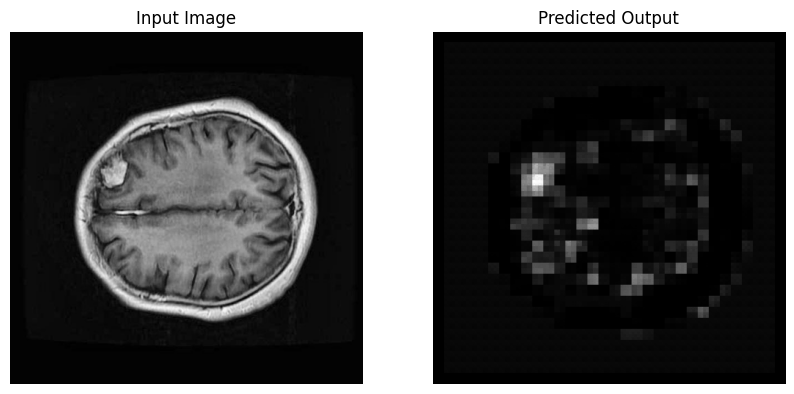

In [6]:
# Save the trained model
torch.save(model.state_dict(), os.path.join(base_dir, 'regularized_model.pth'))

# Load the trained model
model.load_state_dict(torch.load(os.path.join(base_dir, 'regularized_model.pth')))
model.eval()

# Run inference on a sample image
image_path = os.path.join(base_dir, "semantic-segmentation/test2/images/27_jpg.rf.b2a2b9811786cc32a23c46c560f04d07.jpg")
image = Image.open(image_path).convert("L")
input_image = image_transform(image).unsqueeze(0).to(device)

with torch.no_grad():
    output = model(input_image)
output_np = output.squeeze(0).cpu().numpy()

# Plot the input image and the segmentation mask
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Input Image')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(output_np[0], cmap='gray')
plt.title('Predicted Output')
plt.axis('off')
plt.show()

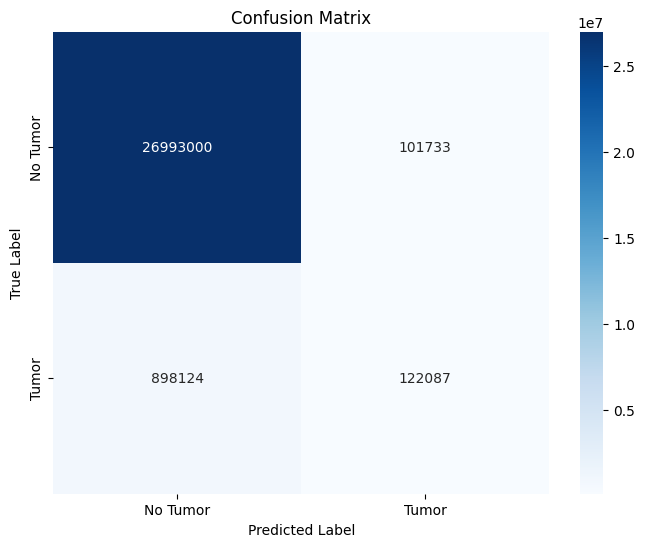

In [7]:
def plot_confusion_matrix(conf_matrix, classes):
    """
    This function plots a given confusion matrix.
    
    Parameters:
    - conf_matrix: numpy array, the confusion matrix to be plotted
    - classes: list of class names for the axis labels
    """
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap=plt.cm.Blues, xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

def incremental_conf_matrix(model, loader, device, classes):
    model.to(device)
    model.eval()
    conf_matrix = np.zeros((len(classes), len(classes)), dtype=int)
    with torch.no_grad():
        for images, masks in loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            # Ensure binary predictions by thresholding and converting to integer
            predicted = (outputs > 0.5).float()
            preds = predicted.view(-1).cpu().numpy().astype(int)  # Ensure binary and convert to int
            actuals = masks.view(-1).cpu().numpy().astype(int)    # Ensure masks are also int

            # Incrementally update confusion matrix
            conf_matrix += confusion_matrix(actuals, preds, labels=range(len(classes)))
    return conf_matrix


model.to(device)

conf_matrix = incremental_conf_matrix(model, valid_loader, device, classes=[0, 1])
plot_confusion_matrix(conf_matrix, classes=['No Tumor', 'Tumor'])




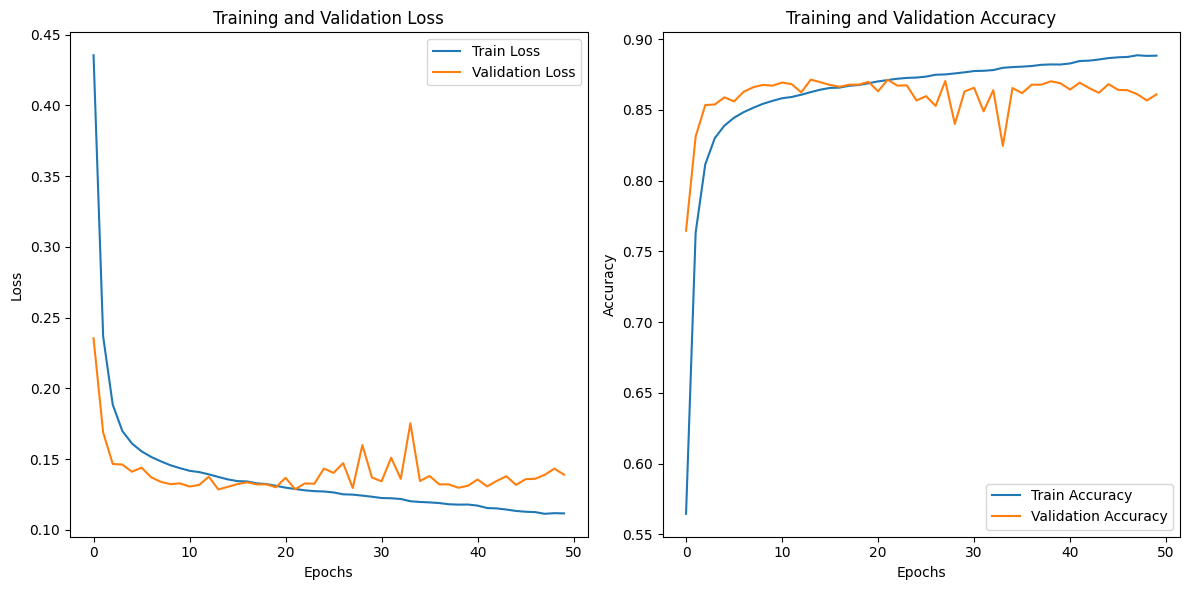

In [8]:
# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Train Loss')
plt.plot(valid_loss_history, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Load training and validation accuracy if calculated
# Assuming train_accuracy_history and valid_accuracy_history are returned and saved from your training function
# If they are not calculated and saved, you would need to implement that similarly to how loss is tracked
train_accuracy_history = [1 - loss for loss in train_loss_history]  # Example calculation, replace with actual if available
valid_accuracy_history = [1 - loss for loss in valid_loss_history]  # Example calculation, replace with actual if available

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracy_history, label='Train Accuracy')
plt.plot(valid_accuracy_history, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()